In [ ]:
!nvidia-smi

In [ ]:
!git clone https://github.com/fizyr/keras-retinanet.git

In [ ]:
!pip install --upgrade keras
!pip install .
!pip install setuptools
!python3 setup.py build_ext --inplace

In [ ]:
!pip install gdown
!pip install tensorflow-gpuf
!pip install pandas
!pip install seaborn
!pip install sklearn
!pip install opencv-python
!pip install xmltodict

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
import urllib
import os
import csv
import cv2
import time
from PIL import Image
import xmltodict
import json
import collections
import os
import random

from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color


In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [ ]:
#json_data_file = '/home/zac/ShadeMyRun/RetinanetKeras/widowmaker_cv/widow_cv.json'
json_data_file = '/home/zac/ShadeMyRun/labels/Bagley2013_4095007N_12204966W.js'
#data_path = '/home/zac/RetinanetKeras/widowmaker_cv/'
data_path = '/home/zac/ShadeMyRun/maps/'

ANNOTATIONS_FILE = 'annotations.csv'
CLASSES_FILE = 'classes.csv'
THRES_SCORE = 0.2
#os.path.join('snapshots', sorted(os.listdir('snapshots'), reverse=True)[0])
model_path = '/home/zac/ShadeMyRun/RetinanetKeras/keras-retinanet/snapshots/'
#PRETRAINED_MODEL = './snapshots/_pretrained_model.h5'
PRETRAINED_MODEL = '_pretrained_model.h5'


In [ ]:
#!gdown --id 1mTtB8GTWs74Yeqm0KMExGJZh1eDbzUlT --output data.json
#!gdown --id 1wPgOBoSks6bTIs9RzNvZf6HWROkciS8R --output snapshots/resnet50_csv_10.h5

In [14]:
datafile = pd.read_json(json_data_file, lines=True)

In [15]:
dataset = dict()
dataset["image_name"] = list()
dataset["x_min"] = list()
dataset["y_min"] = list()
dataset["x_max"] = list()
dataset["y_max"] = list()
dataset["class_name"] = list()

#counter = 0
for index, row in datafile.iterrows():
    for annotation in row["annotation"]:
        dataset["image_name"].append(row["content"])
        dataset["x_min"].append(annotation["x_min"])
        dataset["y_min"].append(annotation["y_min"])
        dataset["x_max"].append(annotation["x_max"])
        dataset["y_max"].append(annotation["y_max"])
        dataset["class_name"].append(annotation["label"])

print("Dataset lengths should match")
print(len(dataset["image_name"]))
print(len(dataset["x_min"]))
print(len(dataset["y_min"]))
print(len(dataset["x_max"]))
print(len(dataset["y_max"]))
print(len(dataset["class_name"]))

Dataset lengths should match
24093
24093
24093
24093
24093
24093


In [16]:
df = pd.DataFrame(dataset)
df.head()

,image_name,x_min,y_min,x_max,y_max,class_name
0,/home/zac/ShadeMyRun/maps/Bagley2013_4095007N_...,282,2,283,4,tree
1,/home/zac/ShadeMyRun/maps/Bagley2013_4095007N_...,203,3,209,6,tree
2,/home/zac/ShadeMyRun/maps/Bagley2013_4095007N_...,283,2,293,6,tree
3,/home/zac/ShadeMyRun/maps/Bagley2013_4095007N_...,20,2,22,6,tree
4,/home/zac/ShadeMyRun/maps/Bagley2013_4095007N_...,868,4,871,6,tree


In [18]:
def show_image_objects(image_row):

  img_path = image_row.image_name
  box = [
    image_row.x_min, image_row.y_min, image_row.x_max, image_row.y_max
  ]

  image = read_image_bgr(img_path)
  
  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

  draw_box(draw, box, color=(255, 255, 0))

  plt.axis('off')
  plt.imshow(draw)
  plt.show()

In [ ]:
def pascal_voc_to_json(file_name):
    json_object_list = dict()
    with open(file_name, 'r') as file:
        json_text = xmltodict.parse(file.read())
        
        #img_name = json_text['annotation']['path'].replace("E:\Widow CV Data\\", cwd)
        img_name = json_text['annotation']['path'].split("\\")[-1]
        img_name = data_path + img_name
        print("Image Name")
        print(img_name)
        json_object_list["content"] = img_name
        json_object_list["annotation"] = []
        object_list = json_text['annotation']['object']
        
        if type(object_list) !=  type(collections.OrderedDict()):
            for single_object in object_list:
                json_object_list["annotation"].append({
                    'label':single_object['name'],
                    'x_min':single_object['bndbox']['xmin'],
                    'y_min':single_object['bndbox']['ymin'],
                    'x_max':single_object['bndbox']['xmax'],
                    'y_max':single_object['bndbox']['ymax'],
                })
        else:
            single_object = object_list
            json_object_list["annotation"].append({
                'label':single_object['name'],
                'x_min':single_object['bndbox']['xmin'],
                'y_min':single_object['bndbox']['ymin'],
                'x_max':single_object['bndbox']['xmax'],
                'y_max':single_object['bndbox']['ymax'],
            })
            
        return json_object_list

In [ ]:
def xml_list_to_json_file(xml_list, output_filename):
    output_filename = output_filename
    with open(output_filename, "w+") as output_file:
        for xml_file in xml_list:
            json = pascal_voc_to_json(xml_file)
            output_file.write(str(json).replace("'", '"') + "\n")
    return output_filename

In [ ]:
# filelist = []
# for filename in os.listdir(data_path):
#   if filename.endswith(".xml"):
#     filelist.append(data_path + filename)
#
# print(len(filelist))
# print(xml_list_to_json_file(filelist, json_data_file))

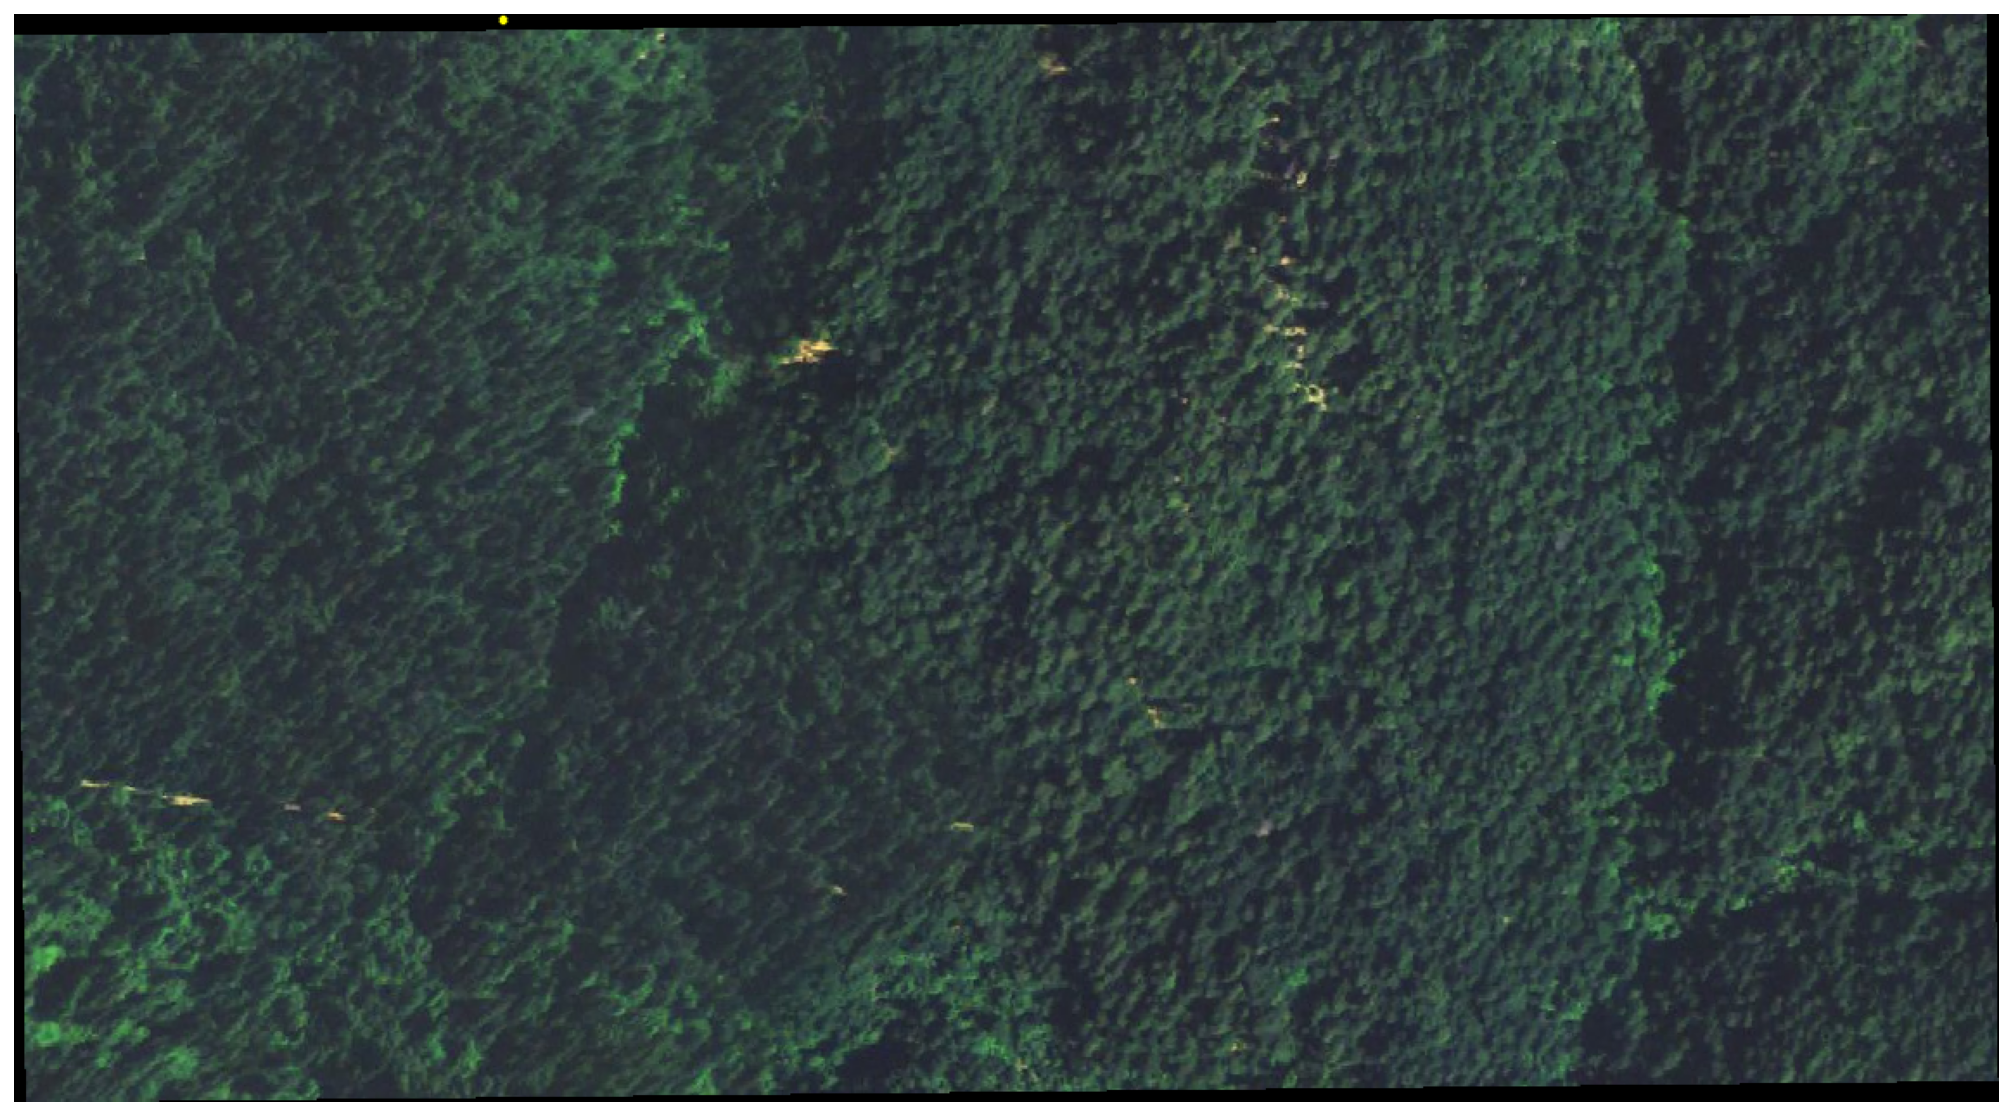

In [19]:
show_image_objects(df.iloc[0])

In [ ]:
show_image_objects(df.iloc[5])

# Preprocessing

In [20]:
RANDOM_SEED = int(random.random() * 1000000)
train_df, test_df = train_test_split(
  df, 
  test_size=0.1, 
  random_state=RANDOM_SEED
)
print(train_df)
print(test_df)

                                              image_name  x_min  y_min  x_max  \
16879  /home/zac/ShadeMyRun/maps/Bagley2013_4095007N_...    689    358    701   
4055   /home/zac/ShadeMyRun/maps/Bagley2013_4095007N_...    785     63    788   
11323  /home/zac/ShadeMyRun/maps/Bagley2013_4095007N_...    325    225    328   
10227  /home/zac/ShadeMyRun/maps/Bagley2013_4095007N_...    472    202    474   
8902   /home/zac/ShadeMyRun/maps/Bagley2013_4095007N_...    309    174    312   
...                                                  ...    ...    ...    ...   
15381  /home/zac/ShadeMyRun/maps/Bagley2013_4095007N_...     27    323     28   
17694  /home/zac/ShadeMyRun/maps/Bagley2013_4095007N_...    598    392    602   
5587   /home/zac/ShadeMyRun/maps/Bagley2013_4095007N_...    841     87    848   
20839  /home/zac/ShadeMyRun/maps/Bagley2013_4095007N_...     24    487     26   
12003  /home/zac/ShadeMyRun/maps/Bagley2013_4095007N_...    161    233    170   

       y_max class_name  
1

In [ ]:
train_df.to_csv(ANNOTATIONS_FILE, index=False, header=None)

In [ ]:
!head classes.csv
!head annotations.csv

# Training

In [25]:
URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'
urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)

print('Downloaded pretrained model to ' + PRETRAINED_MODEL)

Downloaded pretrained model to _pretrained_model.h5


In [ ]:
!keras-retinanet/keras_retinanet/bin/train.py --freeze-backbone --random-transform --batch-size 8 --steps 30 --epochs 10 csv annotations.csv classes.csv
#os.chdir("keras-retinanet")
#!keras_retinanet/bin/train.py --freeze-backbone --random-transform --weights {PRETRAINED_MODEL} --batch-size 8 --steps 30 --epochs 10 csv annotations.csv classes.csv

# Loading the trained model

In [ ]:
!ls snapshots

In [26]:
model_path = os.path.join('snapshots', sorted(os.listdir('snapshots'), reverse=True)[0])
print(model_path)

model = models.load_model(model_path, backbone_name='resnet50')
model = models.convert_model(model)

labels_to_names = pd.read_csv(CLASSES_FILE, header=None).T.loc[0].to_dict()

IndexError: list index out of range

# Predictions

In [ ]:
def predict(image):
  image = preprocess_image(image.copy())
  image, scale = resize_image(image)

  boxes, scores, labels = model.predict_on_batch(
    np.expand_dims(image, axis=0)
  )

  boxes /= scale

  return boxes, scores, labels

In [ ]:
def draw_detections(image, boxes, scores, labels):
  print("Drawing Detections")
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
    if score < THRES_SCORE:
        break

    color = label_color(label)

    b = box.astype(int)
    draw_box(image, b, color=color)

    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(image, b, caption)


In [ ]:
def show_detected_objects(image_row):
  img_path = image_row.image_name
  
  image = read_image_bgr(img_path)

  boxes, scores, labels = predict(image)

  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

  true_box = [
    image_row.x_min, image_row.y_min, image_row.x_max, image_row.y_max
  ]
  draw_box(draw, true_box, color=(255, 255, 0))
  
  draw_detections(draw, boxes, scores, labels)

  plt.axis('off')
  plt.imshow(draw)
  plt.show()

In [ ]:
test_df.head(n=10)

In [ ]:
show_detected_objects(test_df.iloc[0])

In [ ]:
show_detected_objects(test_df.iloc[1])

In [ ]:
show_detected_objects(test_df.iloc[2])

In [ ]:
show_detected_objects(test_df.iloc[15])

In [ ]:
test_df.iloc[4]